<a href="https://colab.research.google.com/github/hasannader/Birthday-gift/blob/main/autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile
import os

# Path to your zip file
zip_path = "/content/drive-download-20250912T092540Z-1-001.zip"

# Destination folder
dest_folder = "/content/data"

# Create destination folder if it doesn't exist
os.makedirs(dest_folder, exist_ok=True)

# Extract zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(dest_folder)

print(f"Unzipped to: {dest_folder}")

Unzipped to: /content/data


In [9]:
# import shutil

# # Replace with your folder path
# folder_path = "/content/jpg_data"

# # Delete the entire folder and its contents
# shutil.rmtree(folder_path)


In [11]:
pip install pillow-heif

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 66.9 MB/s eta 0:00:00


In [12]:
# import os
from PIL import Image
import pillow_heif  # plugin to read HEIC

# Input and output folders
input_dir = "/content/data"
output_dir = "/content/jpg_data"

# Create output folder if not exists
os.makedirs(output_dir, exist_ok=True)

# Loop through files
for filename in os.listdir(input_dir):
    file_path = os.path.join(input_dir, filename)

    # Skip non-files
    if not os.path.isfile(file_path):
        continue

    # Handle HEIC
    if filename.lower().endswith(".heic"):
        heif_file = pillow_heif.read_heif(file_path)
        img = Image.frombytes(
            heif_file.mode,
            heif_file.size,
            heif_file.data,
            "raw"
        )
        new_name = os.path.splitext(filename)[0] + ".jpg"
        img.save(os.path.join(output_dir, new_name), "JPEG")

    # Handle JPG
    elif filename.lower().endswith(".jpg") or filename.lower().endswith(".jpeg"):
        new_name = os.path.splitext(filename)[0] + ".jpg"
        img = Image.open(file_path).convert("RGB")
        img.save(os.path.join(output_dir, new_name), "JPEG")

print("✅ Conversion finished! All images are saved as .jpg in:", output_dir)

✅ Conversion finished! All images are saved as .jpg in: /content/jpg_data


In [ ]:
---------------

In [13]:
import os
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import torch.optim as optim

In [14]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith(('.jpg','.png','.jpeg'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

data_dir = "/content/jpg_data"

transform = transforms.Compose([
    transforms.Resize((1024, 1024)),
    transforms.ToTensor(),
])

dataset = CustomImageDataset(root_dir=data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

In [15]:
# =======================
# 2. Autoencoder Model
# =======================
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  # 512x512
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # 256x256
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1), # 128x128
            nn.ReLU(True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1), # 64x64
            nn.ReLU(True),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1), # 128x128
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1), # 256x256
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 512x512
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),    # 1024x1024
            nn.Sigmoid()  # Keep values between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [18]:
# =======================
# 3. Training
# =======================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 50

for epoch in range(num_epochs):
    for imgs in dataloader:   # ✅ Only imgs (no labels)
        imgs = imgs.to(device)

        # Forward
        outputs = model(imgs)
        loss = criterion(outputs, imgs)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

print("Training finished!")

Epoch [1/50], Loss: 0.0667
Epoch [2/50], Loss: 0.0388
Epoch [3/50], Loss: 0.0191
Epoch [4/50], Loss: 0.0398
Epoch [5/50], Loss: 0.0247
Epoch [6/50], Loss: 0.0104
Epoch [7/50], Loss: 0.0224
Epoch [8/50], Loss: 0.0082
Epoch [9/50], Loss: 0.0105
Epoch [10/50], Loss: 0.0056
Epoch [11/50], Loss: 0.0063
Epoch [12/50], Loss: 0.0057
Epoch [13/50], Loss: 0.0046
Epoch [14/50], Loss: 0.0044
Epoch [15/50], Loss: 0.0039
Epoch [16/50], Loss: 0.0077
Epoch [17/50], Loss: 0.0037
Epoch [18/50], Loss: 0.0036
Epoch [19/50], Loss: 0.0042
Epoch [20/50], Loss: 0.0079
Epoch [21/50], Loss: 0.0062
Epoch [22/50], Loss: 0.0029
Epoch [23/50], Loss: 0.0042
Epoch [24/50], Loss: 0.0042
Epoch [25/50], Loss: 0.0022
Epoch [26/50], Loss: 0.0091
Epoch [27/50], Loss: 0.0031
Epoch [28/50], Loss: 0.0027
Epoch [29/50], Loss: 0.0035
Epoch [30/50], Loss: 0.0033
Epoch [31/50], Loss: 0.0034
Epoch [32/50], Loss: 0.0016
Epoch [33/50], Loss: 0.0044
Epoch [34/50], Loss: 0.0034
Epoch [35/50], Loss: 0.0042
Epoch [36/50], Loss: 0.0020
E

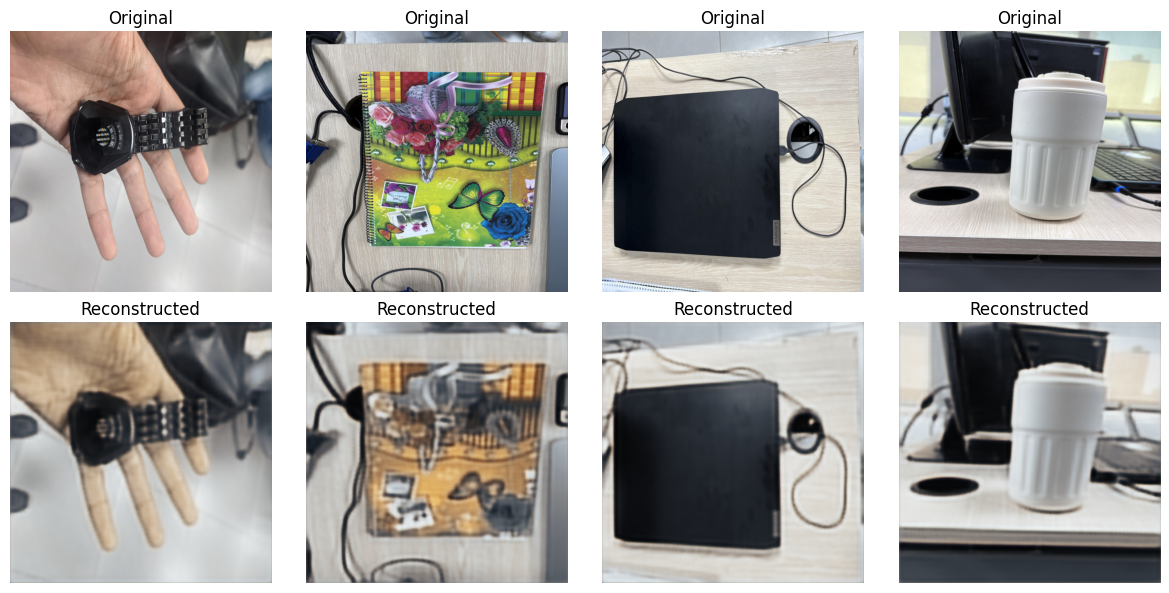

In [19]:
# # =======================
# 4. Test with one batch
# =======================
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    for imgs in dataloader:   # ✅ only imgs
        imgs = imgs.to(device)
        outputs = model(imgs)
        break  # Take first batch

# Move to CPU and convert to numpy
imgs = imgs.cpu().numpy()
outputs = outputs.cpu().numpy()

# Plot originals vs reconstructions
fig, axes = plt.subplots(2, 4, figsize=(12,6))
for i in range(4):
    # Original
    axes[0, i].imshow(imgs[i].transpose(1, 2, 0))
    axes[0, i].set_title("Original")
    axes[0, i].axis("off")

    # Reconstructed
    axes[1, i].imshow(outputs[i].transpose(1, 2, 0))
    axes[1, i].set_title("Reconstructed")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()

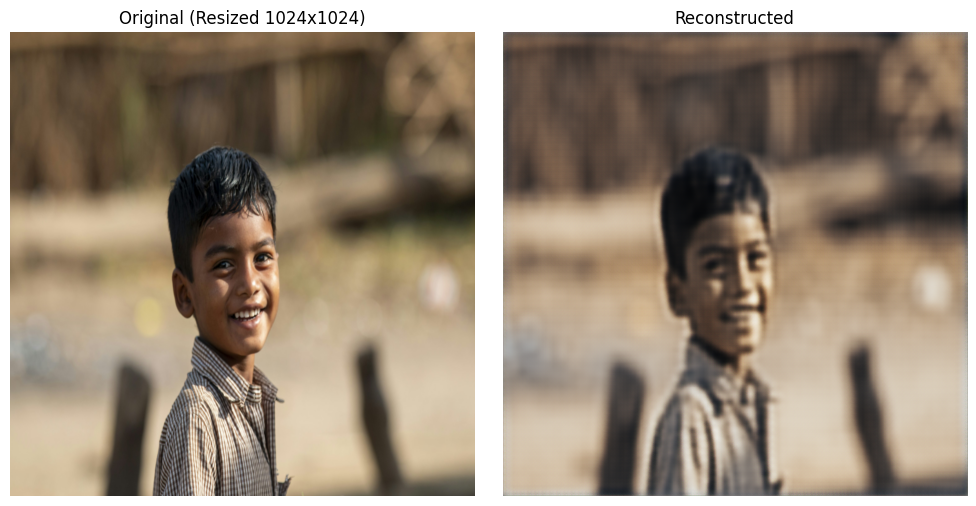

In [21]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

# Path to external image
img_path = "/content/boy.jpg"

# Define preprocessing: resize to 1024x1024 and convert to tensor
transform = transforms.Compose([
    transforms.Resize((1024, 1024)),
    transforms.ToTensor(),
])

# Load and preprocess image
img = Image.open(img_path).convert("RGB")
img_tensor = transform(img).unsqueeze(0).to(device)  # add batch dimension

# Pass through model
model.eval()
with torch.no_grad():
    output = model(img_tensor)

# Move to CPU and convert to numpy
img_np = img_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)
out_np = output.squeeze(0).cpu().numpy().transpose(1, 2, 0)

# Plot original vs reconstruction
fig, axes = plt.subplots(1, 2, figsize=(10,5))

# Original
axes[0].imshow(img_np)
axes[0].set_title("Original (Resized 1024x1024)")
axes[0].axis("off")

# Reconstructed
axes[1].imshow(out_np)
axes[1].set_title("Reconstructed")
axes[1].axis("off")

plt.tight_layout()
plt.show()